In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import torch
import yaml

sys.path.append("src")
from src.deep.deep_music import DeepMUSIC, rmspe_loss, predict
from src.deep.synthetic_data import load_microphones, create_dataset

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [10]:
test_input, test_output, test_n_sources = create_dataset('test_coherent_dataset', 100, coherent=True)

100%|██████████| 100/100 [00:00<00:00, 2857.56it/s]


In [11]:
mics_coords = torch.tensor(load_microphones()).to(device)

# Load the model
with open("conf/deep_music.yaml") as stream:
    try:
        conf = yaml.safe_load(stream)
    except yaml.YAMLError as exc:
        print(exc)


model = DeepMUSIC(mics_coords, conf)

model_path = "checkpoints/model-epoch-5.pt"
model.load_state_dict(torch.load(model_path, map_location=device))
model.to(device)
model.eval()

DeepMUSIC(
  (gru): GRU(48, 256)
  (post_gru): Linear(in_features=256, out_features=1152, bias=True)
  (neural_net): NeuralNet(
    (linear_relu_stack): Sequential(
      (0): Linear(in_features=1000, out_features=256, bias=True)
      (1): GELU(approximate='none')
      (2): Linear(in_features=256, out_features=256, bias=True)
      (3): GELU(approximate='none')
      (4): Linear(in_features=256, out_features=24, bias=True)
    )
  )
)

tensor(0.2100, dtype=torch.float64)


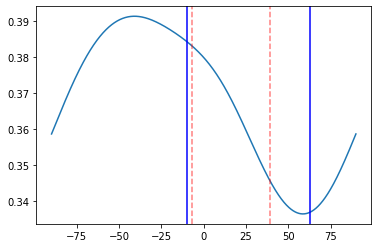

In [13]:
ind = 0

estimations, spectrum = predict(model, test_input[ind], 2)
doas = test_output[ind]

X = np.linspace(-90, 90, len(spectrum))
plt.plot(X, spectrum)

print(rmspe_loss(torch.tensor(estimations), doas, 2))

for pred, true in zip(estimations, doas):
  angle = (true + np.pi/2) % (np.pi) - np.pi/2
  plt.axvline(angle * 180 / np.pi, color='r', alpha=0.5, linestyle='--')
  angle = (pred + np.pi/2) % (np.pi) - np.pi/2
  plt.axvline(angle * 180 / np.pi, color='b')

In [14]:
def compute_test_loss(test_input, test_output, n_sources):
  losses = np.zeros(len(test_input))

  for i, (a, doas) in enumerate(zip(test_input, test_output)):
    predicted, _ = predict(model, a, n_sources)
    losses[i] = rmspe_loss(torch.tensor(predicted), torch.tensor(doas), n_sources)

  return np.mean(losses)

compute_test_loss(test_input, test_output, 2)

0.1870417785133375